In [1]:
from glob import glob
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle
from parcels import ErrorCode, AdvectionRK4_3D, Variable, Field
from parcels.application_kernels.TEOSseawaterdensity import PolyTEOS10_bsq

from datetime import timedelta
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Lorenz - MOi fields
data_path = '/storage/shared/oceanparcels/input_data/MOi/2019/'
# bio_data_path = '/storage/shared/oceanparcels/input_data/MOi/biomer4v2r1/'

output_path = '/storage/shared/oceanparcels/output_data/' + \
    'data_Claudio/backtrack_loc0_column.nc'

ufiles = []
vfiles = []
wfiles = []
tfiles = []
sfiles = [] 
twoDfiles = []

for i in range(8, 10):
    ufiles = ufiles + sorted(glob(data_path + f'psy4v3r1-daily_U_201{i}*.nc'))
    vfiles = vfiles + sorted(glob(data_path + f'psy4v3r1-daily_V_201{i}*.nc'))
    wfiles = wfiles + sorted(glob(data_path + f'psy4v3r1-daily_W_201{i}*.nc'))
    tfiles = tfiles + sorted(glob(data_path + f'psy4v3r1-daily_T_201{i}*.nc'))    
    sfiles = sfiles + sorted(glob(data_path + f'psy4v3r1-daily_S_201{i}*.nc'))
    twoDfiles = twoDfiles + sorted(glob(data_path + f'psy4v3r1-daily_2D_201{i}*.nc'))

# phfiles = sorted(glob(bio_data_path + 'biomer4v2r1-weekly_ph_2019*.nc'))

mesh_mask = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/coordinates.nc'
bathy_file = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc'
# mesh_mask_bio = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA025-N006/coordinates.nc'


to implement
- sample bathymetry to stop particles once they reach the sea floor [**DONE**]
- fix issue with reading files beyond 2019 [**Half-done**] _there is a file from 2017 year that isn't working._
- ~rungekutta method~ _It cannot be implemented easily because the $v_s$ doesn't depend on time, but on the sorrounding density, and it's not straight forward to do that within Parcels._


In [4]:
filenames = {'U': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': ufiles},
             'V': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': vfiles},
             'W': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': wfiles}}

filenames['cons_temperature'] = {'lon': mesh_mask, 
                                 'lat': mesh_mask, 
                                 'depth': wfiles[0], 
                                 'data': tfiles}
filenames['abs_salinity'] = {'lon': mesh_mask, 
                             'lat': mesh_mask, 
                             'depth': wfiles[0], 
                             'data': sfiles}

filenames['mld'] = {'lon': mesh_mask, 
                     'lat': mesh_mask,
                     'depth': twoDfiles[0],
                     'data': twoDfiles}


In [5]:
n_points = 100
particle_size = 0.0001 #
initial_depth = 5

start_time = datetime.strptime('2019-12-20 12:00:00', '%Y-%m-%d %H:%M:%S')
# psy4v3r1-daily_2D_2019-01-01.nc

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz'}

variables['cons_temperature'] = 'votemper'
variables['abs_salinity'] = 'vosaline'
variables['mld'] = 'somxlavt'

dimensions = {'U': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'V': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'W': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'}}

dimensions['cons_temperature'] = {'lon': 'glamf', 
                                  'lat': 'gphif',
                                  'depth': 'depthw', 
                                  'time': 'time_counter'}

dimensions['abs_salinity'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'depthw', 
                              'time': 'time_counter'}

dimensions['mld'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'deptht', 
                              'time': 'time_counter'}



In [6]:
indices = {'lat': range(750, 1300), 'lon': range(2900, 4000)}

In [7]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                              allow_time_extrapolation=False,
                              indices=indices)


         It will be opened with no decoding. Filling values might be wrongly parsed.


In [8]:
fieldset.add_constant('viscosity', 1e-6)
fieldset.add_constant('particle_density', 1380)

bathy = xr.load_dataset(bathy_file)

fieldset.add_field(Field('bathymetry', bathy['Bathymetry'].values,
                         lon=bathy['nav_lon'].values, lat=bathy['nav_lat'].values,
                         mesh='spherical'))


In [9]:
class PlasticParticle(JITParticle):
    cons_temperature = Variable('cons_temperature', dtype=np.float32, initial=fieldset.cons_temperature)
    abs_salinity = Variable('abs_salinity', dtype=np.float32, initial=fieldset.abs_salinity)
    mld = Variable('mld', dtype=np.float32, initial=fieldset.mld)
    density = Variable('density', dtype=np.float32, initial=1035)
    v_s = Variable('v_s', dtype=np.float32, initial=0)
    alpha = Variable('alpha', dtype=np.float32, initial=particle_size)
    

In [10]:
lon_cluster = [6.287]*n_points
lat_cluster = [-32.171]*n_points

# depth_cluster = np.linspace(1, 5000, n_points)
depth_cluster = np.ones(n_points)*initial_depth #meters

date_cluster = [start_time]*n_points

lon_cluster = np.array(lon_cluster)+(np.random.random(len(lon_cluster))-0.5)/24
lat_cluster = np.array(lat_cluster)+(np.random.random(len(lat_cluster))-0.5)/24

In [11]:
pset = ParticleSet.from_list(fieldset=fieldset, pclass=PlasticParticle,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             depth=depth_cluster,
                             time=date_cluster)


In [12]:
def delete_particle(particle, fieldset, time):
    particle.delete()

In [13]:
def GrowParticle(particle, fieldset, time):
    particle.alpha = particle.alpha - fieldset.grow_rate*particle.dt

In [ ]:
def AdvectionRK4_1D(particle, fieldset, time):
    """
    Advection of particles using fourth-order Runge-Kutta integration including vertical velocity.
    Function needs to be converted to Kernel object before execution
    """
    (w1) = fieldset.W[time, particle.depth, particle.lat, particle.lon]
    depth_1 = particle.depth + w1 * .5 * particle.dt
    
    (w2) = fieldset.W[time + .5 * particle.dt, depth_1, particle.lat, particle.lon]
    depth_2 = particle.depth + w2 * .5 * particle.dt
    
    (w3) = fieldset.W[time + .5 * particle.dt, depth_2, particle.lat, particle.lon]
    depth_3 = particle.depth + w3 * particle.dt
    
    (w4) = fieldset.W[time + particle.dt, depth_3, particle.lat, particle.lon]

    particle.depth += (w1 + 2 * w2 + 2 * w3 + w4) / 6. * particle.dt

In [ ]:
def SinkingVelocity_RK4(particle, fieldset, time):
    g = 9.81
    dt = particle.dt
    rho_p = fieldset.particle_density ##
    
    nu = fieldset.viscosity
    alpha = particle.alpha
    
    
    
    rho_f = particle.density
    
    beta = 3*rho_f/(2*rho_p + rho_f)
    tau_p = alpha*alpha/(3*beta*nu) ## alpha*alpha
    
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    
    if particle.depth < seafloor and particle.depth > 0:
        v_s = (1 - beta)*g*tau_p
    else:
        v_s = 0
        
    particle.v_s = v_s
    particle.depth = particle.depth + v_s*dt

In [1]:
def PolyTEOS10_bsq(Z, SA, CT):
    Z = - Z #particle.depth  # note: use negative depths!
#     SA = fieldset.abs_salinity[time, particle.depth, particle.lat, particle.lon]
#     CT = fieldset.cons_temperature[time, particle.depth, particle.lat, particle.lon]

    SAu = 40 * 35.16504 / 35
    CTu = 40
    Zu = 1e4
    deltaS = 32
    R000 = 8.0189615746e+02
    R100 = 8.6672408165e+02
    R200 = -1.7864682637e+03
    R300 = 2.0375295546e+03
    R400 = -1.2849161071e+03
    R500 = 4.3227585684e+02
    R600 = -6.0579916612e+01
    R010 = 2.6010145068e+01
    R110 = -6.5281885265e+01
    R210 = 8.1770425108e+01
    R310 = -5.6888046321e+01
    R410 = 1.7681814114e+01
    R510 = -1.9193502195e+00
    R020 = -3.7074170417e+01
    R120 = 6.1548258127e+01
    R220 = -6.0362551501e+01
    R320 = 2.9130021253e+01
    R420 = -5.4723692739e+00
    R030 = 2.1661789529e+01
    R130 = -3.3449108469e+01
    R230 = 1.9717078466e+01
    R330 = -3.1742946532e+00
    R040 = -8.3627885467e+00
    R140 = 1.1311538584e+01
    R240 = -5.3563304045e+00
    R050 = 5.4048723791e-01
    R150 = 4.8169980163e-01
    R060 = -1.9083568888e-01
    R001 = 1.9681925209e+01
    R101 = -4.2549998214e+01
    R201 = 5.0774768218e+01
    R301 = -3.0938076334e+01
    R401 = 6.6051753097e+00
    R011 = -1.3336301113e+01
    R111 = -4.4870114575e+00
    R211 = 5.0042598061e+00
    R311 = -6.5399043664e-01
    R021 = 6.7080479603e+00
    R121 = 3.5063081279e+00
    R221 = -1.8795372996e+00
    R031 = -2.4649669534e+00
    R131 = -5.5077101279e-01
    R041 = 5.5927935970e-01
    R002 = 2.0660924175e+00
    R102 = -4.9527603989e+00
    R202 = 2.5019633244e+00
    R012 = 2.0564311499e+00
    R112 = -2.1311365518e-01
    R022 = -1.2419983026e+00
    R003 = -2.3342758797e-02
    R103 = -1.8507636718e-02
    R013 = 3.7969820455e-01
    ss = math.sqrt((SA + deltaS) / SAu)
    tt = CT / CTu
    zz = -Z / Zu
    rz3 = R013 * tt + R103 * ss + R003
    rz2 = (R022 * tt + R112 * ss + R012) * tt + (R202 * ss + R102) * ss + R002
    rz1 = (((R041 * tt + R131 * ss + R031) * tt + (R221 * ss + R121) * ss + R021) * tt + ((R311 * ss + R211) * ss + R111) * ss + R011) * tt + (((R401 * ss + R301) * ss + R201) * ss + R101) * ss + R001
    rz0 = (((((R060 * tt + R150 * ss + R050) * tt + (R240 * ss + R140) * ss + R040) * tt + ((R330 * ss + R230) * ss + R130) * ss + R030) * tt + (((R420 * ss + R320) * ss + R220) * ss + R120) * ss + R020) * tt + ((((R510 * ss + R410) * ss + R310) * ss + R210) * ss + R110) * ss + R010) * tt + (((((R600 * ss + R500) * ss + R400) * ss + R300) * ss + R200) * ss + R100) * ss + R000
    density = ((rz3 * zz + rz2) * zz + rz1) * zz + rz0
    
    return density

In [14]:
def SinkingVelocity(particle, fieldset, time):
    rho_p = fieldset.particle_density ##
    rho_f = particle.density
    nu = fieldset.viscosity
    alpha = particle.alpha
    g = 9.81
    dt = particle.dt
    beta = 3*rho_f/(2*rho_p + rho_f)
    tau_p = alpha*alpha/(3*beta*nu) ## alpha*alpha
    
    seafloor = fieldset.bathymetry[time, particle.depth, particle.lat, particle.lon]
    
    if particle.depth < seafloor and particle.depth > 0:
        v_s = (1 - beta)*g*tau_p
    else:
        v_s = 0
        
    particle.v_s = v_s
    particle.depth = particle.depth + v_s*dt
    

In [15]:
def SampleField(particle, fielset, time):
    particle.cons_temperature = fieldset.cons_temperature[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.abs_salinity = fieldset.abs_salinity[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.mld = fieldset.mld[time, particle.depth, 
                                               particle.lat, particle.lon]


In [16]:
kernels = pset.Kernel(AdvectionRK4_3D) + pset.Kernel(SampleField) + pset.Kernel(PolyTEOS10_bsq) + pset.Kernel(SinkingVelocity)

# Output fileii
output_file = pset.ParticleFile(name=output_path,
                                outputdt=timedelta(hours=24))

pset.execute(kernels,
             output_file=output_file,
             runtime=timedelta(days=10),
             dt=-timedelta(hours=1),
             recovery={ErrorCode.ErrorOutOfBounds: delete_particle})

output_file.close()

sh: None: command not found
INFO: Compiled ArrayPlasticParticleAdvectionRK4_3DSampleFieldPolyTEOS10_bsqSinkingVelocity ==> /tmp/parcels-263482/lib94e6b9d139456baafa203850cc9c15df_0.so
INFO: Temporary output files are stored in /storage/shared/oceanparcels/output_data/data_Claudio/out-KVDQWHJQ.
INFO: You can use "parcels_convert_npydir_to_netcdf /storage/shared/oceanparcels/output_data/data_Claudio/out-KVDQWHJQ" to convert these to a NetCDF file during the run.
N/A% (0 of 864000.0) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING: ParticleSet is empty on writing as array at time 6.16032e+07
 50% (432000.0 of 864000.0) |######      | Elapsed Time: 0:00:03 ETA:   0:00:03WARNING: ParticleSet is empty on writing as array at time 6.15168e+07
 60% (518400.0 of 864000.0) |#######     | Elapsed Time: 0:00:06 ETA:   0:00:12WARNING: ParticleSet is empty on writing as array at time 6.14304e+07
 70% (604800.0 of 864000.0) |########    | Elapsed Time: 0:00:09 ETA:   0:00:09WARNING: 

In [17]:
sim = xr.load_dataset(output_path)

In [18]:
sim

<xarray.Dataset>
Dimensions:           (traj: 100, obs: 11)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory        (traj, obs) float64 0.0 0.0 0.0 0.0 ... 99.0 99.0 99.0
    time              (traj, obs) datetime64[ns] 2019-12-20T12:00:00 ... 2019...
    lat               (traj, obs) float64 -32.17 -32.2 -32.22 ... -32.39 -32.41
    lon               (traj, obs) float64 6.293 6.396 6.485 ... 6.923 6.986 7.05
    z                 (traj, obs) float64 2e+03 1.991e+03 ... 1.991e+03
    cons_temperature  (traj, obs) float32 2.776 2.778 2.791 ... 2.775 2.775
    abs_salinity      (traj, obs) float32 34.8 34.81 34.8 ... 34.78 34.79 34.78
    mld               (traj, obs) float32 43.7 44.2 43.64 ... 10.46 10.46 10.46
    density           (traj, obs) float32 1.035e+03 1.028e+03 ... 1.028e+03
    v_s               (traj, obs) float32 0.0 7.473e-05 ... 7.474e-05 7.474e-05
    alpha             (traj, obs) float32 1e-05 1e-05 1e-05 ... 1e-05 1e-05
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

In [14]:
sim['z']

<xarray.DataArray 'z' (traj: 100, obs: 11)>
array([[2000.        , 1997.44507147, 1993.90045867, ..., 1977.20146243,
        1977.06155112, 1977.38237652],
       [2000.        , 1997.27993032, 1993.54394644, ..., 1973.24312218,
        1973.26943778, 1973.59020717],
       [2000.        , 1997.36181643, 1993.73314905, ..., 1976.06673513,
        1975.95432042, 1976.27512945],
       ...,
       [2000.        , 1997.33296935, 1995.05243284, ..., 1977.49255508,
        1976.97483944, 1976.99884521],
       [2000.        , 1998.00416301, 1995.68480672, ..., 1979.0097692 ,
        1978.32281872, 1978.09181836],
       [2000.        , 1997.36897179, 1994.50542582, ..., 1977.72806755,
        1977.40771768, 1977.72854819]])
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      
    standard_name:  depth
    units:          m
    positive:       down

Text(0, 0.5, 'Particle size')

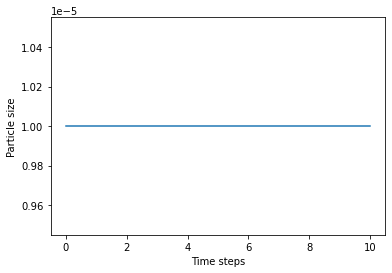

In [19]:
plt.plot(sim['alpha'][0, :])
plt.xlabel('Time steps')
plt.ylabel('Particle size')

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

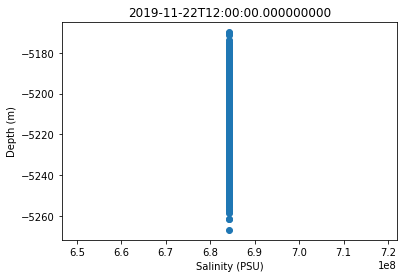

In [24]:
step = 10
plt.scatter(sim['alpha'][:,step], -sim['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

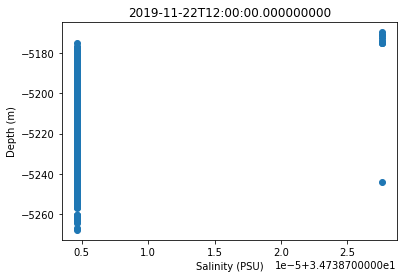

In [19]:
step = 10
plt.scatter(sim['salinity'][:,step], -sim['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

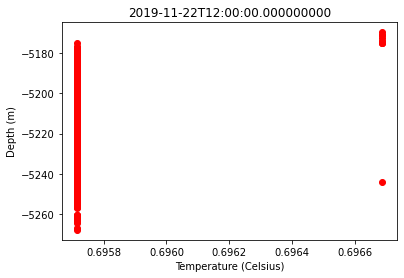

In [20]:
step = 10
plt.scatter(sim['temperature'][:,step], -sim['z'][:,step], color='r')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

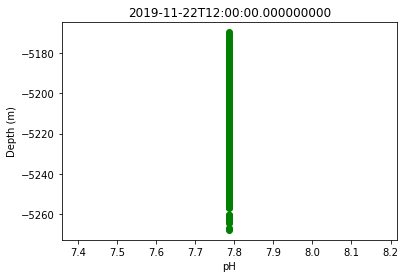

In [21]:
step = 10
plt.scatter(sim['ph'][:,step], -sim['z'][:,step], color='g')
plt.xlabel('pH')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0, 0.5, 'Latitude')

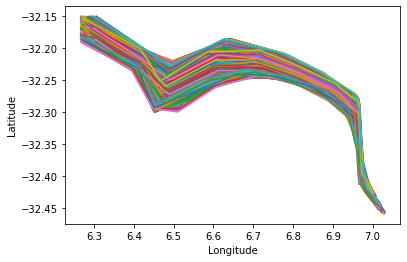

In [23]:
step = 10
for i in range(1000):
    plt.plot(sim['lon'][i,:], sim['lat'][i,:]);

plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title(sim['time'][0,step].values)

In [3]:
sim2 = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/SA_5m_s02.nc')

In [4]:
sim2

<xarray.Dataset>
Dimensions:           (traj: 1000, obs: 301)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory        (traj, obs) float64 0.0 0.0 0.0 0.0 ... 999.0 999.0 999.0
    time              (traj, obs) datetime64[ns] 2019-12-30T12:00:00 ... 2019...
    lat               (traj, obs) float64 -32.16 -32.22 -32.3 ... -32.87 -32.84
    lon               (traj, obs) float64 6.289 6.657 7.008 ... 41.16 41.11
    z                 (traj, obs) float64 5.0 5.064 5.142 ... 65.26 64.61 63.93
    cons_temperature  (traj, obs) float32 18.89 18.94 19.01 ... 19.41 19.24
    abs_salinity      (traj, obs) float32 35.69 35.67 35.66 ... 35.62 35.62
    mld               (traj, obs) float32 0.0 46.08 50.73 ... 11.27 10.64 11.52
    alpha             (traj, obs) float32 1e-06 1e-06 1e-06 ... 1e-06 1e-06
    density           (traj, obs) float32 1.035e+03 1.025e+03 ... 1.025e+03
    v_s               (traj, obs) float32 0.0 7.538e-07 ... 7.543e-07 7.542e-07
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

In [5]:
import cartopy as cart
import cartopy.crs as ccrs
# import cmocean.cm as cmo
# import seaborn as sns
from glob import glob

Text(0, 0.5, 'Latitude')

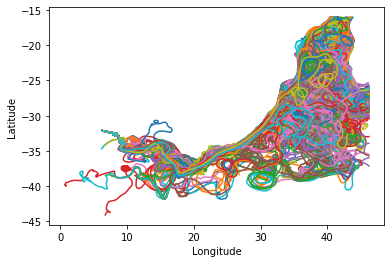

In [6]:
step = 10
for i in range(1000):
    plt.plot(sim2['lon'][i,:], sim2['lat'][i,:]);

plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [45]:
step = 10
plt.scatter(sim2['salinity'][:,step], -sim2['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim2['time'][0,step].values)

KeyError: 'salinity'